epoch: 100, 对'time traveller'的预测:time traveller and the the the the the the the the the the the t
epoch: 200, 对'time traveller'的预测:time traveller parked four dimension ward whicinving oved tat at
epoch: 300, 对'time traveller'的预测:time travellerit s against reasof said filbycan a cubee tom cand
epoch: 400, 对'time traveller'的预测:time travellerisms neaster the prave cbetane dofe sare uxtinal s
epoch: 500, 对'time traveller'的预测:time traveller for so it will be convenient to speak of himwas e
困惑度1.03, 185065.9词元/秒 在cuda:0上
对prefix为'time traveller'的预测:time traveller for so it will be convenient to speak of himwas e
对prefix为'traveller'的预测:travelleryou can show black is white by argument said filby


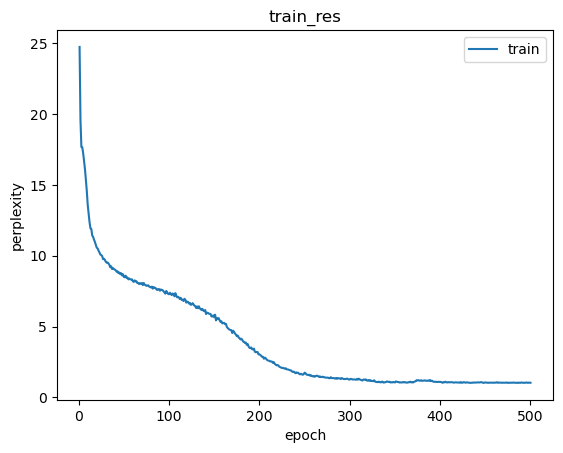

In [1]:
import utils, torch
from torch import nn
from torch.nn import functional as F

# 从头实现的RNN
"""
独热编码:
独热编码将每个索引映射为相互不同的单位向量:假设词表中不同词元的数目为N(即len(vocab)),
词元索引的范围为0到N-1。如果词元的索引是整数i,那么将创建一个长度为N的全0向量,并将第i处的元素设置为1。
此向量是原始词元的一个独热向量。
 
每次采样的小批量数据形状是二维张量:(批量大小,时间步数)。
one_hot函数将这样一个小批量数据转换成三维张量,张量的最后一个维度等于词表大小(len(vocab))。
转换输入的维度，以便获得形状为（时间步数，批量大小，词表大小）的输出(对于原始的批量数据进行了转置)。
这将能够更方便地通过最外层的维度，一步一步地更新小批量数据的隐状态
"""
def init_rnn_state(self, batch_size, num_hiddens, device):
        """
        一个在初始化RNN时返回隐状态(即初始化隐状态)的函数\n
        隐状态可能包含多个变量的情况，使用元组可以更容易地处理些,所以返回元组。\n
        返回:\n 
        RNN的隐状态,是一个全用0填充的张量,形状为(批量大小, 隐藏单元数)。
        """
        return (torch.zeros((batch_size, num_hiddens), device=device),)

def rnn_forward(self, inputs, state):
        """
        rnn_forward函数定义了如何在一个时间步内计算隐状态和输出。
        循环神经网络模型通过inputs最外层的维度实现循环,以便逐时间步更新小批量数据的隐状态H。
        这里使用tanh函数作为激活函数,是因为当元素在实数上满足均匀分布时,tanh函数的平均值为0。\n
        参数:\n
        inputs: 批量矩阵X转置后的独热编码,形状为(时间步数量, 批量大小, 词表大小), 每一行是批量矩阵中各个样本在某一时间步的特征\n
        state: 上一时间步的隐状态，张量变量，形状为(批量大小,隐藏单元数)\n
        返回:\n
        形状为(num_steps*batch_size, num_outputs)的预测序列 和 输出层的隐藏状态
        """
        W_xh, W_hh, b_h, W_hq, b_q = self.params
        H, = state
        outputs = []
        for X in inputs: # 按照时间步顺序进行迭代 t1-->t2-->tn 注意inputs是之前批量矩阵的转置
            # 取出的矩阵X的每一行是一个样本, 纵行是独热编码的特征
            H = torch.tanh(torch.matmul(X, W_xh) + torch.matmul(H, W_hh) + b_h) # 由上一个隐状态和输入得到现在的隐状态 shape=(batch_size, num_hiddens)
            Y = torch.matmul(H, W_hq) + b_q # 由隐状态得到输出, 是一个形状为(batch_size, num_outputs(即词表大小))的矩阵
            outputs.append(Y) # 逐时间步追加,最后再连接得到的就是num_steps个时间步的输出序列
        return torch.concat(outputs, dim=0), (H,) # 返回预测的输出序列和新的隐状态

def init_params_rnn(self, vocab_size, num_hiddens, device):
        """
        初始化模型参数\n
        vocab_size: 词表大小\n
        num_hiddens: 隐藏单元个数 是可调的超参数
        """
        def normal(shape):
            return torch.randn(size=shape, device=device) * 0.01

        # 训练语言模型时,输入和输出来自相同的词表。因此它们具有相同的维度，即词表的大小。
        num_inputs = num_outputs = vocab_size
        # 隐藏层参数
        W_xh = normal((num_inputs, num_hiddens))
        W_hh = normal((num_hiddens, num_hiddens))
        b_h = torch.zeros(num_hiddens, device=device)
        # 输出层参数
        W_hq = normal((num_hiddens, num_outputs))
        b_q = torch.zeros(num_outputs, device=device)
        # 附加梯度
        params = [W_xh, W_hh, b_h, W_hq, b_q]
        for param in params:
            param.requires_grad_(True)
        return params

class RNNScratch():
    def __init__(self, vocab_size, num_hiddens, init_params_fn, forward_fn, init_state_fn, device) -> None:
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = init_params_fn(vocab_size, num_hiddens, device)
        self.forward_fn, self.init_state_fn = forward_fn, init_state_fn

    def __call__(self, X, state):
        """
        参数:\n
        X : 形状为(批量大小, 时间步数量)\n
        state : 前一个时间步的隐状态，张量变量，形状为(批量大小,隐藏单元数)
        """
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state_fn(batch_size, self.num_hiddens, device)

batch_size = 32
num_epochs, lr = 500, 1
num_steps = 35
num_hiddens = 512
train_iter, vocab = utils.load_time_machine_data(batch_size, num_steps)
net = RNNScratch(len(vocab), num_hiddens, init_params_rnn, rnn_forward, init_rnn_state, device=utils.try_gpu())
utils.rnn_train(net, train_iter, vocab, lr, num_epochs, device=utils.try_gpu())